# **CUDA-Q Basics**

This notebook is designed for learning the fundamental concepts of quantum computing, the motivation for quantum programming, and the CUDA-Q platform. It sets the stage for hands-on exploration with single and multi-qubit systems, quantum gates, and measurement. Simply set up CUDA-Q by importing `cudaq` along with necessary libraries:

In [1]:
import cudaq
import numpy as np

## Learning Objectives

1. **Quantum States** and **Visualization**
2. **Single-Qubit Quantum Programs**: Gate Operations, Superposition, and Measurements
3. **Multi-Qubit Programming** with Entanglement
4. **Nested Quantum Kernels**
5. **Advanced CUDA-Q Kernels**: Adjoint, Conditionals, and Variational Algorithms

---

## 1. Quantum States and Visualization

In quantum computing, a **quantum state** represents the condition of a qubit or system of qubits. Unlike classical bits that are either 0 or 1, qubits can exist in a **superposition** of both states simultaneously. Understanding and visualizing these quantum states is fundamental to quantum programming.

**Key Concepts:**
- **Quantum State Representation**: In CUDA-Q, quantum states are described by complex-valued amplitudes. For a single qubit, the state |ψ⟩ = α|0⟩ + β|1⟩, where |α|² + |β|² = 1.
- **Bloch Sphere**: A geometric representation of single-qubit states as points on a sphere, making abstract quantum states intuitive and visual.

**CUDA-Q APIs Covered:**
- `@cudaq.kernel`: Decorator that defines a quantum program (kernel) that will execute on a quantum processor or simulator
- `cudaq.qvector`: Creates a quantum register initialized with specified state coefficients
- `cudaq.get_state`: Retrieves the quantum state vector from a kernel execution
- `cudaq.add_to_bloch_sphere`: Prepares a Bloch sphere visualization object
- `cudaq.show`: Displays the visualization

In the following example, we'll create a simple quantum state and visualize it on the Bloch sphere to understand how quantum states are represented in CUDA-Q.

### Example: Defining and Visualizing the Zero State


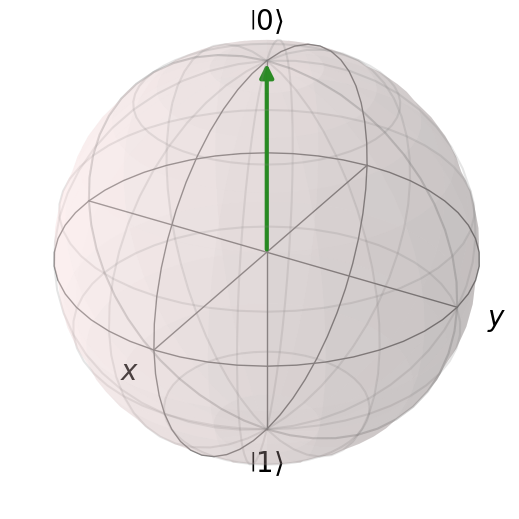

In [2]:
# Define coefficients for the zero state: |0⟩
c = [complex(1, 0), complex(0, 0)]

@cudaq.kernel
def zero_state():
    q = cudaq.qvector(c)


# Visualize the state on the Bloch sphere
sphere = cudaq.add_to_bloch_sphere(cudaq.get_state(zero_state))
cudaq.show(sphere)

## 2. Single-Qubit Quantum Programs

Now that we understand quantum states, let's explore how to manipulate them using **quantum gates**. Quantum gates are the building blocks of quantum circuits, analogous to logic gates in classical computing. They transform quantum states through unitary operations, preserving the fundamental property that probabilities sum to 1.

**Key Concepts:**
- **Quantum Gates**: Operations that rotate or flip qubits on the Bloch sphere (e.g., X gate for bit flip, H gate for superposition)
- **Superposition**: A qubit state that is a combination of |0⟩ and |1⟩, enabling quantum parallelism
- **Measurement**: The process of observing a quantum state, which collapses it to either |0⟩ or |1⟩ with certain probabilities
- **Sampling**: Running a quantum program multiple times to estimate measurement probabilities

**CUDA-Q APIs Covered:**
- `cudaq.qubit()`: Allocates a single qubit initialized to |0⟩
- `x(qubit)`: Applies the Pauli-X (NOT) gate to flip the qubit state
- `h(qubit)`: Applies the Hadamard gate to create superposition
- `mz(qubit)`: Measures the qubit in the computational (Z) basis
- `cudaq.sample`: Executes the kernel multiple times (`shots_count`) and returns measurement statistics
- `cudaq.draw`: Generates a visual representation of the quantum circuit
- `result.most_probable()`: Returns the measurement outcome with highest frequency
- `result.probability`: Returns the probability of a specific measurement outcome

The following examples demonstrate fundamental single-qubit operations: bit flipping and creating superposition states.

### Example: Bit Flip Operation


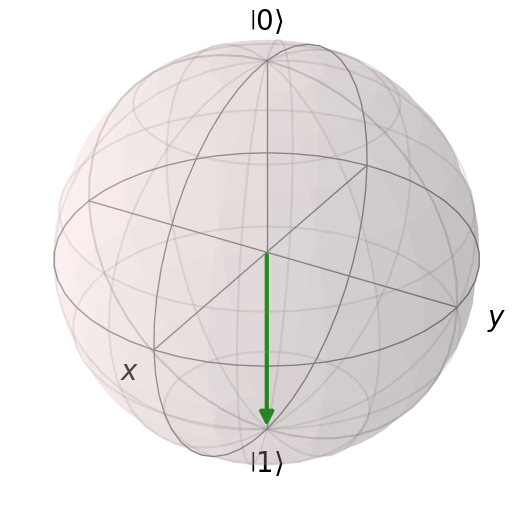

Result from sampling 1000 times: { 1:1000 }

Most probable result: 1
Measured with probability 1.0


In [3]:
@cudaq.kernel
def bitflip():
    qubit = cudaq.qubit()
    x(qubit)


# Visualize the state after the X gate
sphere = cudaq.add_to_bloch_sphere(cudaq.get_state(bitflip))
cudaq.show(sphere)

# Sample the kernel
shots = 1000
result = cudaq.sample(bitflip, shots_count=shots)
print(f"Result from sampling {shots} times: {result}")
print(f"Most probable result: {result.most_probable()}")
print(f"Measured with probability {result.probability(result.most_probable())}")

For all supported gate operations, please kindly refer to this [page](https://nvidia.github.io/cuda-quantum/latest/api/default_ops.html#). Feel free to try experimenting with other quantum gates to see how they affect the qubit state.

### Example: Superposition and Measurement

- Hadamard gate to create |+⟩ = (1/√2)|0⟩ + (1/√2)|1⟩
- Sampling to observe probabilistic outcomes

In [4]:
@cudaq.kernel
def plus_kernel():
    qubit = cudaq.qubit()
    h(qubit)
    mz(qubit)


print(cudaq.draw(plus_kernel))

shots = 1000
result = cudaq.sample(plus_kernel, shots_count=shots)
print("The sampling result:", result)

     ╭───╮
q0 : ┤ h ├
     ╰───╯

The sampling result: { 0:488 1:512 }



### (Optional) Example: Single Qubit U3 Gate

The **U3 gate** is a universal single-qubit rotation gate—meaning any single-qubit operation can be constructed using `U3`. It takes three parameters (θ, φ, λ) and has the matrix form:
$$
U3(\theta, \phi, \lambda) = 
\begin{bmatrix}
\cos\left(\frac{\theta}{2}\right) & -e^{i\lambda} \sin\left(\frac{\theta}{2}\right) \\
e^{i\phi} \sin\left(\frac{\theta}{2}\right) & e^{i(\phi + \lambda)} \cos\left(\frac{\theta}{2}\right)
\end{bmatrix}
$$

**Special cases of U3 include familiar gates**: 
  - `u3(π/2, 0, π)` = Hadamard gate
  - `u3(π, 0, π)` = Pauli-X gate

Let's use CUDA-Q's built-in `u3` operation to recreate these gates and explore arbitrary state preparation:

=== U3 Implementation of Hadamard Gate ===
The sampling result: { 0:498 1:502 }

=== U3 Implementation of Pauli-X Gate ===
The sampling result: { 1:1000 }


=== Arbitrary State Vector ===
State amplitudes: [ 0.707+0.j  -0.5  -0.5j]


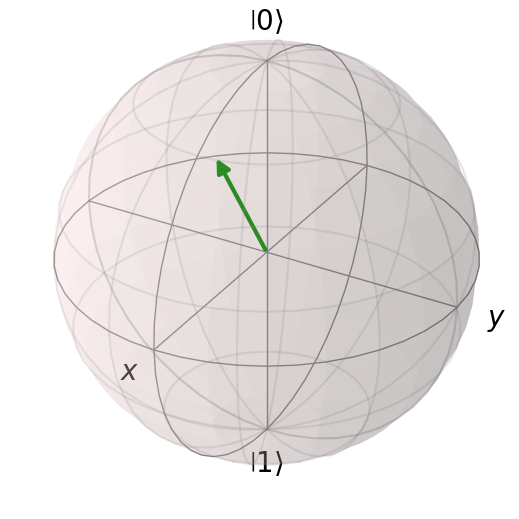

In [5]:
@cudaq.kernel
def u3_state(theta: float, phi: float, lam: float):
    qubit = cudaq.qubit()
    u3(theta, phi, lam, qubit)


# Create Hadamard gate using U3
print("=== U3 Implementation of Hadamard Gate ===")
counts = cudaq.sample(u3_state, np.pi/2, 0.0, np.pi)
print(f"The sampling result: {counts}")

# Create Pauli-X gate using U3
print("=== U3 Implementation of Pauli-X Gate ===") 
counts = cudaq.sample(u3_state, np.pi, 0.0, np.pi)
print(f"The sampling result: {counts}")

# Demonstrate state vector preparation
print("\n=== Arbitrary State Vector ===")
state = cudaq.get_state(u3_state, -np.pi/2, np.pi/4, -np.pi/3)
print(f"State amplitudes: {np.round(state, 3)}")

sphere = cudaq.add_to_bloch_sphere(state)
cudaq.show(sphere)

### (Optional) Example: Custom Operation for Square Root of X Gate

Square Root of NOT (√X) Gate
- **Definition**: A quantum gate where $(\sqrt{X})^2 = X$
- **Property**: Applying it twice flips the qubit (like the X gate)
- **Matrix form**:  
  $$
  \sqrt{X} = 
  \begin{bmatrix}
  \frac{1+i}{2} & \frac{1-i}{2} \\
  \frac{1-i}{2} & \frac{1+i}{2}
  \end{bmatrix}
  $$

The `cudaq.register_operation` function allows you to register custom quantum operations with their unitary matrices, creating reusable custom gates that extend CUDA-Q's built-in gate set and can be used like standard gates in quantum kernels.


In [6]:
# Step 1: Define the unitary matrix for square root of X (NOT) gate
sqrt_x_matrix = np.array([
    [(1 + 1j)/2, (1 - 1j)/2],
    [(1 - 1j)/2, (1 + 1j)/2]
], dtype=complex)

# Step 2: Register the custom operation with CUDA-Q
cudaq.register_operation("sqrt_x", sqrt_x_matrix)

# Step 3: Verify (√X)² = X mathematically
x_gate = np.array([[0, 1], [1, 0]], dtype=complex)
sqrt_x_squared = sqrt_x_matrix @ sqrt_x_matrix
print(f"Verification: (√X)² equals X? {np.allclose(sqrt_x_squared, x_gate)}")

# Step 4: Use the custom gate in CUDA-Q kernels
@cudaq.kernel
def sqrt_x_twice():
    """Apply custom √X gate twice"""
    qubit = cudaq.qubit()
    sqrt_x(qubit)
    sqrt_x(qubit) 
    mz(qubit)

@cudaq.kernel
def x_gate():
    """Apply X gate once for comparison"""
    qubit = cudaq.qubit()
    x(qubit)
    mz(qubit)

# Step 5: Test and compare results
print("\n=== Quantum Circuit Testing ===\n")
sqrt_x_results = cudaq.sample(sqrt_x_twice, shots_count=1000)
x_results = cudaq.sample(x_gate, shots_count=1000)

print(f"√X applied twice: {sqrt_x_results}")
print(f"X applied once:   {x_results}")

Verification: (√X)² equals X? True

=== Quantum Circuit Testing ===

√X applied twice: { 1:1000 }

X applied once:   { 1:1000 }



## 3. Multi-Qubit Programming with Entanglement

As we scale from single qubits to multiple qubits, quantum computing reveals its true power through **entanglement**—a uniquely quantum phenomenon where qubits become correlated in ways impossible in classical systems. When qubits are entangled, measuring one instantly affects the state of the others, regardless of distance.

**Key Concepts:**
- **Quantum Registers**: Collections of multiple qubits that work together as a system
- **Multi-Qubit Gates**: Operations that act on two or more qubits simultaneously (e.g., CNOT/controlled-X gate)
- **Entanglement**: A quantum correlation where the state of the entire system cannot be described by the individual states of its parts
- **Bell States**: Maximally entangled two-qubit states, fundamental to quantum communication and teleportation

**CUDA-Q APIs Covered:**
- `cudaq.qvector(n)`: Allocates a register of n qubits, all initialized to |0⟩
- `qvector[i]`: Accesses the i-th qubit in the register (zero-indexed)
- `x.ctrl(control_qubit, target_qubit)`: Applies a controlled-X (CNOT) gate—flips the target qubit if the control qubit is |1⟩
- `mz(qvector)`: Measures all qubits in the register

**Understanding the Bell State:**
The Bell state (|Φ⁺⟩ = (|00⟩ + |11⟩)/√2) is created by:
1. Applying Hadamard to the first qubit: creates superposition (|0⟩ + |1⟩)/√2
2. Applying CNOT with the first qubit as control: entangles both qubits

The result is remarkable: measurements always yield either "00" or "11" with equal probability—the qubits are perfectly correlated.

### Example: Bell State (Entanglement)

In [7]:
@cudaq.kernel
def bell_state():
    q = cudaq.qvector(2)
    h(q[0])
    x.ctrl(q[0], q[1])
    mz(q)


print(cudaq.draw(bell_state))

shots = 1000
result = cudaq.sample(bell_state, shots_count=shots)
print("The sampling result:", result)

     ╭───╮     
q0 : ┤ h ├──●──
     ╰───╯╭─┴─╮
q1 : ─────┤ x ├
          ╰───╯

The sampling result: { 00:475 11:525 }



## 4. Nested CUDA-Q Kernels

As quantum programs grow in complexity, **modular programming** becomes essential. CUDA-Q supports nested kernels, allowing you to define reusable quantum subroutines that can be called within larger quantum programs—similar to functions in classical programming.

**Benefits of Nested Kernels:**
1. **Modularity**: Build complex quantum circuits from simpler, reusable components organized hierarchically
2. **Reusability**: Define common quantum operations once and use them across multiple programs and contexts
3. **Abstraction**: Hide implementation details and express algorithms in terms of high-level operations
4. **Maintainability**: Update a subroutine once, and all dependent programs benefit automatically

In the following example, we'll create reusable quantum subroutines for common operations and compose them into a larger program. One kernel can call another by simply invoking it with the appropriate arguments:

In [8]:
@cudaq.kernel
def minus(qubit: cudaq.qubit):
    x(qubit)
    h(qubit)

@cudaq.kernel
def xgate(qubits: cudaq.qvector):
    x(qubits)

@cudaq.kernel
def nested_quantum_kernel(num_qubits: int):
    qvector = cudaq.qvector(num_qubits)
    xgate(qvector)
    minus(qvector[1])


num_qubits = 2
print(cudaq.draw(nested_quantum_kernel, num_qubits))

shots = 1000
result = cudaq.sample(nested_quantum_kernel, num_qubits, shots_count=shots)
print("The sampling result:", result)

     ╭───╮          
q0 : ┤ x ├──────────
     ├───┤╭───╮╭───╮
q1 : ┤ x ├┤ x ├┤ h ├
     ╰───╯╰───╯╰───╯

The sampling result: { 10:477 11:523 }



## 5. Advanced CUDA-Q Kernels: Adjoint, Conditionals, and Variational Algorithms

Having mastered the basics, we now explore advanced CUDA-Q features that enable sophisticated quantum algorithms used in real-world applications. These capabilities include reversing quantum operations, making decisions based on measurement results, and optimizing quantum circuits—techniques essential for quantum chemistry, machine learning, and optimization problems.

**Key Concepts:**
- **Adjoint Operations**: The quantum equivalent of "undo"—reverses a gate by applying its inverse (conjugate transpose)
- **Mid-Circuit Measurements**: Measuring qubits during computation (not just at the end) and using results to control subsequent operations
- **Conditional Logic**: Making classical decisions based on quantum measurement outcomes within a quantum program
- **Variational Quantum Algorithms (VQA)**: Hybrid quantum-classical algorithms that optimize circuit parameters to minimize an objective function (e.g., finding ground state energies)

**CUDA-Q APIs Covered:**
- `gate.adj()`: Applies the adjoint (inverse) of a quantum gate
- `reset(qubit)`: Resets a qubit to the |0⟩ state
- `cudaq.spin`: Module for defining quantum Hamiltonians using Pauli operators
- `cudaq.observe`: Computes the expectation value ⟨H⟩ of a given Hamiltonian
- `cudaq.optimizers`: Built-in optimization algorithms (Adam, COBYLA, etc.)
- `cudaq.gradients`: Gradient calculation methods (parameter shift, finite difference)
- `result.get_register_counts`: Retrieves measurement statistics for a specific register

**Applications:**
- **Quantum Chemistry**: Finding molecular ground states and energy surfaces
- **Quantum Machine Learning**: Training parameterized quantum circuits
- **Optimization**: Solving combinatorial problems like MaxCut, TSP

The following examples demonstrate these advanced features, culminating in a complete variational algorithm for molecular simulation.

### Example: Adjoint Kernel of a Rotation Gate

In [9]:
@cudaq.kernel
def rotation():
    q = cudaq.qvector(1)
    rx(np.pi, q)

print(cudaq.draw(rotation))


@cudaq.kernel
def adjoint_rotation():
    q = cudaq.qvector(1)
    rx.adj(np.pi, q)


print(cudaq.draw(adjoint_rotation))

     ╭───────────╮
q0 : ┤ rx(3.142) ├
     ╰───────────╯

     ╭────────────╮
q0 : ┤ rx(-3.142) ├
     ╰────────────╯



### Example: Conditional Measurement

Quantum kernels can use mid-circuit measurement result to control subsequent operations. This example demonstrates:

1. **Measure and reset**: Apply Hadamard to qubit 0, measure it (saving result as `midCircuit`), then reset and flip to |1⟩
2. **Conditional logic**: Apply Hadamard to qubit 1 only if `midCircuit` measured 1

**Expected outcome:** Qubit 0 is always 1 (confirming the reset worked), while qubit 1 shows a 75/25 distribution. This is because there's a 50% chance `midCircuit`=1 triggers the Hadamard on qubit 1, creating a 50/50 superposition that results in 75% "10" and 25% "11".

In [10]:
@cudaq.kernel
def kernel():
    q = cudaq.qvector(2)

    h(q[0])                  # Create superposition
    midCircuit = mz(q[0])    # Measure qubit 0
    reset(q[0])              # Reset to |0⟩
    x(q[0])                  # Flip to |1⟩

    if midCircuit:           # Conditional on measurement
        h(q[1])              # Create superposition on qubit 1


result = cudaq.sample(kernel)

# Access the `__global__` measurement counts
global_counts = result.get_register_counts('__global__')
print("Global counts:", global_counts)

# Access the `midCircuit` measurement counts
midCircuit_counts = result.get_register_counts('midCircuit')
print("midCircuit counts:", midCircuit_counts)

Global counts: { 10:713 11:287 }

midCircuit counts: { 0:487 1:513 }



### Example: Variational Quantum Algorithm (VQA)

Many quantum algorithms require optimizing circuit parameters to minimize expectation values. CUDA-Q provides multiple optimization approaches:

1. **Built-in CUDA-Q optimizers and gradients**
2. **Third-party optimizers** (e.g., SciPy)

In [11]:
from cudaq import spin


# Define Hamiltonian for H2 molecule
hamiltonian = 5.907 - 2.1433 * spin.x(0) * spin.x(1) - 2.1433 * spin.y(0) * spin.y(1) + 0.21829 * spin.z(0) - 6.125 * spin.z(1)

@cudaq.kernel
def kernel(angles: list[float]):
    qubits = cudaq.qvector(2)
    h(qubits)                       # Initialize qubits to superposition with equal amplitude  
    ry(angles[0], qubits[0])        # Variational rotation on qubit 0
    ry(angles[1], qubits[1])        # Variational rotation on qubit 1
    x.ctrl(qubits[0], qubits[1])    # CNOT gate 


initial_params = np.random.normal(0, np.pi, 2)
print(cudaq.draw(kernel, initial_params))

     ╭───╮╭─────────────╮     
q0 : ┤ h ├┤ ry(-0.3789) ├──●──
     ├───┤├────────────┬╯╭─┴─╮
q1 : ┤ h ├┤ ry(-4.988) ├─┤ x ├
     ╰───╯╰────────────╯ ╰───╯



**Method 1: Built-in CUDA-Q Optimizers**

CUDA-Q provides various optimizers for different optimization needs. You can find these optimizers in the [API reference](https://nvidia.github.io/cuda-quantum/latest/api/languages/python_api.html#optimizers).
In this session, we use CUDA-Q's built-in Adam optimizer with parameter shift:

In [12]:
optimizer = cudaq.optimizers.Adam()
optimizer.step_size = 0.1    # (Optional) Specify learning rate for Adam or other gradient-based optimizers
optimizer.initial_parameters = initial_params
gradient = cudaq.gradients.ParameterShift()

def objective_function(parameter_vector):
    # Cost function using CUDA-Q observe
    get_result = lambda params: cudaq.observe(kernel, hamiltonian, params).expectation()
    
    cost = get_result(parameter_vector)
    gradient_vector = gradient.compute(parameter_vector, get_result, cost)
    
    return cost, gradient_vector


# Optimize
energy, parameter = optimizer.optimize(dimensions=len(initial_params), function=objective_function)

print(f"Minimized <H> = {round(energy, 16)}")
print(f"Optimal theta = {parameter}")

Minimized <H> = -1.748456749908259
Optimal theta = [0.9909301513473945, -4.7185304285357095]


**Method 2: Third-Party Optimizers**

Use SciPy's optimization functions with a simple cost function:

In [13]:
from scipy.optimize import minimize


def cost(params):
    return cudaq.observe(kernel, hamiltonian, params).expectation()


result = minimize(cost, initial_params, method='COBYLA', options={'maxiter': 40})
print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.7488649071406441
       x: [ 9.766e-01 -4.712e+00]
    nfev: 37
   maxcv: 0.0


---

## End of CUDA-Q Basics Tutorial

🎉 **Congratulations!** You've completed the CUDA-Q Basics tutorial and learned the fundamental concepts of quantum computing with CUDA-Q!

You've explored:
- Quantum states and visualization
- Single-qubit and multi-qubit gates
- Entanglement and Bell states
- Modular programming with nested kernels
- Advanced features like adjoint operations, conditional logic, and variational algorithms

**Where to go next?**

Continue your quantum computing journey by exploring:
- 📚 [NVIDIA CUDA-Q Documentation](https://nvidia.github.io/cuda-quantum/latest/index.html) – Comprehensive guides and API references
- 💻 [CUDA-Q GitHub Repository](https://github.com/NVIDIA/cuda-quantum) – Source code, examples, and community discussions
- 🎓 [CUDA-Q Academic](https://github.com/NVIDIA/cuda-q-academic) – Educational resources and research materials

Happy quantum programming! 🛸